In [1]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
import numpy as np
import math, copy, time
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
sns.set_context(context="talk")

import os, re, sys
import pandas as pd
import ast, time
import matplotlib.pyplot as plt
#conda install -c conda-forge imbalanced-learn
from imblearn.over_sampling import SMOTE
import re, io, nltk, torch 
from numpy.linalg import norm
from tqdm import tqdm, trange
from gensim import utils, matutils  # utility fnc for pickling, common scipy operations etc
from gensim.corpora.dictionary import Dictionary
from six import string_types, integer_types
from six.moves import zip, range
from scipy import stats
from gensim.utils import deprecated
from numpy import dot, float32 as REAL, memmap as np_memmap, \
    double, array, zeros, vstack, sqrt, newaxis, integer, \
    ndarray, sum as np_sum, prod, argmax
from collections import Counter
from scipy.spatial import distance
from numpy.random import binomial
from nltk.corpus import stopwords
from collections import Counter

from sklearn.utils import class_weight
from sklearn.preprocessing import normalize
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

import keras
from keras.callbacks import Callback,ModelCheckpoint, ReduceLROnPlateau    
from keras import backend as K
from keras.preprocessing import sequence
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Embedding
from keras.layers import Conv1D, Conv2D, MaxPooling1D, Input
from keras.models import Model
from keras.layers import LSTM,GRU,Dense
from keras.utils import Sequence,to_categorical
from keras.preprocessing.sequence import pad_sequences

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.autograd import Variable


import transformers
from transformers import (
    WEIGHTS_NAME,
    AdamW,
    BertConfig,
    BertForMaskedLM,
    BertForSequenceClassification,
    BertTokenizer,
    CamembertConfig,
    CamembertForMaskedLM,
    CamembertTokenizer,
    DistilBertConfig,
    DistilBertForMaskedLM,
    DistilBertTokenizer,
    GPT2Config,
    GPT2LMHeadModel,
    GPT2Tokenizer,
    OpenAIGPTConfig,
    OpenAIGPTLMHeadModel,
    OpenAIGPTTokenizer,
    RobertaConfig,
    RobertaForMaskedLM,
    RobertaTokenizer,
    get_linear_schedule_with_warmup,
)

stoplist = stopwords.words("english")

emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
def my_cleaner(post):      
    s= re.sub(r"http\S+", "html", post)   ##########elimina http    
    s= re.sub(r'#\w+ ?', "hashtag", s) ########3
    s= re.sub(r'@\w+ ?', "user", s)##############    
    s= s.lower()    
    s=emoji_pattern.sub(r'', s)
    sl= list(s.split())  
    sl=[word for word in sl if word not in stoplist]
    s=' '.join([word for word in s.split() if word not in stoplist])
    return s, sl

def focal_loss(gamma=2., weights=1):   #weights np.asarray()
    weights= K.variable(weights)
    def focal_loss_fixed(y_true, y_pred):
        y_true = K.clip(y_true, K.epsilon(),1)
        y_pred = K.clip(y_pred,K.epsilon(),1)
        return - K.sum(weights* K.pow(1. - y_pred, gamma)* y_true * K.log(y_pred), axis=-1) 
    return focal_loss_fixed

class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []

    def on_epoch_end(self, batch, logs={}):
        prob = self.model.predict(self.validation_data[0])
        predict = np.squeeze(prob>=0.5)*1
        targ = np.squeeze(self.validation_data[1])
        f1s = f1_score(targ, predict, average='macro')
        self.val_f1s.append(f1s)
        print(" - val_f1: %f " %(f1s))
        return

def plot_confusion_matrix(cm, target_names, title='Confusion matrix (f1-score)',cmap=None, normalize=True):
    
    import itertools
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
    
def train_model(model, x_train, y_train, x_val, y_val, class_weights, e=20, BS=32, verb=1, focal=False):
    if focal:
        model.compile(loss=focal_loss(2,weights=class_weights),optimizer='adam',metrics=['acc'])
    else:
        model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
    
    calls = []
    metrics = Metrics()
    calls.append(metrics)
    """
    mcp_save = ModelCheckpoint(save_f, save_best_only=True, monitor='val_loss', mode='min')
    calls.append(mcp_save)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode ='min',factor=0.2,patience=10, min_lr=0.001)
    if not focal:
        calls.append(reduce_lr)"""
    if not focal:
        hist=model.fit(x_train, y_train, batch_size=BS, epochs=e, verbose=verb, validation_data=(x_val,y_val), class_weight=class_weights, callbacks=calls)
    else:
        hist=model.fit(x_train, y_train, batch_size=BS, epochs=e, verbose=verb, validation_data=(x_val,y_val), callbacks=calls)
        
    plt.figure(figsize=(10,4))
    plt.plot(hist.history['loss'],label="train_loss")
    plt.plot(hist.history['val_loss'],label="val_loss")
    plt.title("Model Loss") 
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(loc="upper right")
    plt.show()

    plt.figure(figsize=(10,4))
    plt.plot(hist.history['acc'],label="Train accuracy" )
    plt.plot(hist.history['val_acc'],label="Val accuracy" )
    plt.title("Model Accuracy") 
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(loc="upper right")
    plt.show()
    
    plt.figure(figsize=(10,4))
    plt.plot(hist.history['val_loss'],label="loss" )
    plt.plot(hist.history['val_acc'],label="accuracy" )
    plt.plot(metrics.val_f1s,label="F-score" )
    plt.ylabel("Metric")
    plt.xlabel('Epochs')
    plt.title("Val metrics")
    plt.legend(loc="upper left")
    plt.show()
    
    return model 

Using TensorFlow backend.


In [2]:
#qscd
d_lab=dict()
d_lab["questioning"]=0
d_lab["support"]=1
d_lab["commenting"]=2
d_lab["denying"]=3


In [3]:
train =pd.read_csv("../Fine-Tuning/CSV_Stance/train_semeval_raw.csv")
val=pd.read_csv("../Fine-Tuning/CSV_Stance/dev_semeval_raw.csv")
test=pd.read_csv("../Fine-Tuning/CSV_Stance/test_semeval_raw.csv")

print ("Conteo por stance\n", Counter(train['Label']))

dir_path='../../model_save/Dos-Fases-all_Stance/'
tokenizer_loaded = BertTokenizer.from_pretrained(dir_path)#'bert-base-uncased')
model_loaded = BertForSequenceClassification.from_pretrained(dir_path, num_labels=4)#'bert-base-uncased',  num_labels=4) 

idx_2_token = tokenizer_loaded.ids_to_tokens

archivo = open(dir_path+'vocab.txt','r')
Word2Index={word.strip():i for i,word in enumerate(archivo.readlines())}

M_BERT_space = model_loaded.bert.embeddings.word_embeddings.weight.detach().cpu().numpy()
print ("M_BERT_space.shape", M_BERT_space.shape)



etiq=[]
for et in train['Label'].values:
    etiq.append(d_lab[et])
print ("etiq train [0:10]", etiq[0:10])
etiq_v=[]
for et in val['Label'].values:
    etiq_v.append(d_lab[et])
print ("etiq val [0:10]", etiq_v[0:10])

sentences = train['Tweet'].values
n_labels = np.array(etiq)

input_ids = []
for sent in sentences:
    encoded_sent = tokenizer_loaded.encode(my_cleaner(sent)[0],add_special_tokens = False)    
    input_ids.append(encoded_sent)
print('Max train sentence length: ', max([len(sen) for sen in input_ids]))

MAX_LEN = 50

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)
print('\nPadding token: "{:}", ID: {:}'.format(tokenizer_loaded.pad_token, tokenizer_loaded.pad_token_id))

# Pad our input tokens with value 0.
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

n_labels = np.array(etiq)
n_labels_val = np.array(etiq_v)
y_train=to_categorical(n_labels,num_classes=4)
y_val=to_categorical(n_labels_val,num_classes=4)



class_weights = class_weight.compute_class_weight('balanced', np.unique(etiq), etiq)
print ("class_weights Training set", class_weights)

shape=np.asarray(input_ids).shape
x_train=np.zeros((shape[0], shape[1], 768))
i=0
for in_id in input_ids:
    x_train[i]=M_BERT_space[in_id]
    i+=1

sentences_val = val['Tweet'].values
input_ids_val = []

# For every sentence...
for sent in sentences_val:
    encoded_sent = tokenizer_loaded.encode(my_cleaner(sent)[0],add_special_tokens = False)    
    input_ids_val.append(encoded_sent)

input_ids_val = pad_sequences(input_ids_val, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

shape_val=np.asarray(input_ids_val).shape

x_val=np.zeros((shape_val[0], shape_val[1], 768))
i=0
for in_id in input_ids_val:
    x_val[i]=M_BERT_space[in_id]
    i+=1

Conteo por stance
 Counter({'commenting': 2734, 'support': 841, 'denying': 333, 'questioning': 330})
M_BERT_space.shape (30522, 768)
etiq train [0:10] [0, 2, 2, 1, 0, 0, 2, 2, 2, 2]
etiq val [0:10] [1, 2, 2, 2, 0, 1, 2, 2, 2, 2]
Max train sentence length:  51

Padding/truncating all sentences to 50 values...

Padding token: "[PAD]", ID: 0
class_weights Training set [3.21060606 1.25980975 0.38752743 3.18168168]


In [5]:
x_train.shape

(4238, 50, 768)

In [43]:
x_smote=x_train.reshape(x_train.shape[0],x_train.shape[1]*x_train.shape[2])
print (x_smote.shape)

sm = SMOTE(random_state=27, n_jobs=-1, sampling_strategy='not majority')
x_new_train, y_new_train = sm.fit_sample(x_smote, y_train)

(4238, 38400)


In [94]:
x_new_train, y_new_train = sm.fit_sample(x_smote, y_train)
x_new_train.shape

(10936, 38400)

In [95]:
y_train.shape

(4238, 4)

In [96]:
y_new_train.shape

(10936, 4)

In [63]:
del tokenizer_loaded 
del model_loaded 

#### In Table 1 we show the parameters of each architecture

CNN1

- 1 capa relu 
- out: softmax
- focal loss

CNN2 

- 2 capas relu 
- out: softmax
- focal loss

RNN1

- 2 capas gru
- out: softmax
- focal loss

RNN2

- 3 capas gru
- out: softmax
- focal loss


RNN3

- 3 capas gru
- out: softmax
- Categorical Cross Entropy



## Modelos base

In [ ]:
np.save("Data_SMOTE_AWE/x_train.npy", x_train_smote)
np.save("Data_SMOTE_AWE/y_train.npy", y_train)
np.save("Data_SMOTE_AWE/x_val.npy", x_val_smote)
np.save("Data_SMOTE_AWE/y_val.npy", y_val)
np.save("Data_SMOTE_AWE/x_test.npy", x_test_smote)
np.save("Data_SMOTE_AWE/y_test.npy", y_test)

In [3]:
x_train=np.load('Data_SMOTE_AWE/x_train.npy')
y_train=np.load('Data_SMOTE_AWE/y_train.npy')
x_val=np.load('Data_SMOTE_AWE/x_val.npy')
y_val=np.load('Data_SMOTE_AWE/y_val.npy')
x_test=np.load('Data_SMOTE_AWE/x_test.npy')
y_test=np.load('Data_SMOTE_AWE/y_test.npy')

In [4]:
etiq=[np.argmax(y) for y in y_train]
etiq_v=[np.argmax(y) for y in y_val]
etiq_t=[np.argmax(y) for y in y_test]

In [5]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(etiq), etiq)
print ("class_weights Training set", class_weights)

class_weights Training set [1. 1. 1. 1.]


In [6]:
x_train.shape

(10936, 38400, 1)

x_new_train=np.expand_dims(x_new_train, axis=-1)
x_new_train.shape
x_new_val=np.expand_dims(x_new_val, axis=-1)
x_new_val.shape
x_new_test=np.expand_dims(x_new_test, axis=-1)
x_new_test.shape

## CNN1 concatenate

In [7]:
sequence_input = Input(shape=x_train.shape[1:])
batch = BatchNormalization()(sequence_input)
cov1= Conv1D(128, 5, activation='relu',padding='same')(batch)
pool = MaxPooling1D(pool_size=3)(cov1)    
batch = BatchNormalization()(pool)
drop = Dropout(0.65)(batch)
cov1= Conv1D(64, 5, activation='relu',padding='same')(drop)
pool = MaxPooling1D(pool_size=3)(cov1)
batch = BatchNormalization()(pool)
drop = Dropout(0.65)(batch)
flat = Flatten()(drop)
preds = Dense(100, activation='relu')(flat)
preds = BatchNormalization()(preds)
preds = Dense(4, activation='softmax')(preds)
cnn1 = Model(sequence_input, preds)
cnn1.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 38400, 1)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 38400, 1)          4         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 38400, 128)        768       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 12800, 128)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 12800, 128)        512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 12800, 128)        0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 12800, 64)         4102

 - val_f1: 0.045307 
 - val_f1: 0.130878 
 - val_f1: 0.280477 
 - val_f1: 0.244895 
 - val_f1: 0.398582 
 - val_f1: 0.408445 
 - val_f1: 0.344656 
 - val_f1: 0.296815 
 - val_f1: 0.395287 
 - val_f1: 0.348462 
 - val_f1: 0.376955 
 - val_f1: 0.403108 
 - val_f1: 0.393477 
 - val_f1: 0.297444 
 - val_f1: 0.397060 
 - val_f1: 0.311927 
 - val_f1: 0.398151 
 - val_f1: 0.381123 
 - val_f1: 0.386428 
 - val_f1: 0.436222 
 - val_f1: 0.404524 
 - val_f1: 0.401339 
 - val_f1: 0.423740 
 - val_f1: 0.424096 
 - val_f1: 0.426221 
 - val_f1: 0.453734 
 - val_f1: 0.399555 
 - val_f1: 0.408624 
 - val_f1: 0.400417 
 - val_f1: 0.379383 


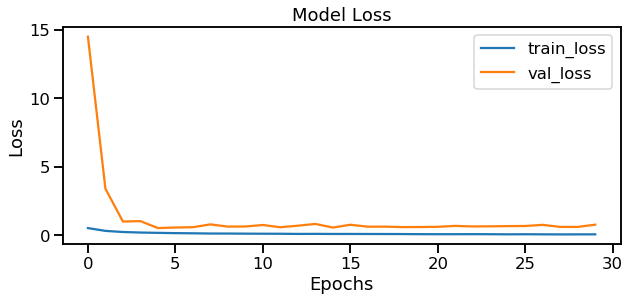

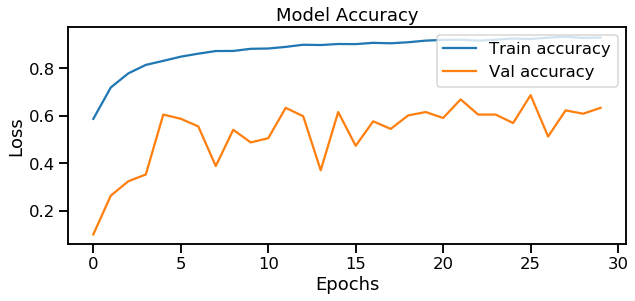

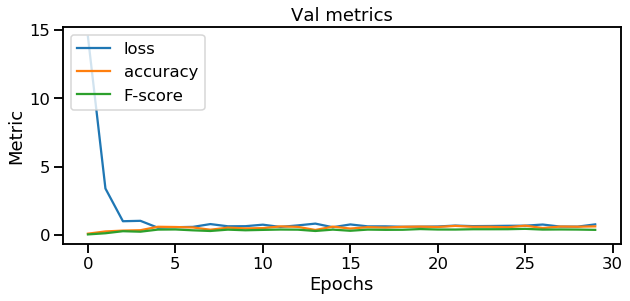

In [8]:
trained =train_model(cnn1, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
trained.save('baselines_fromCIARP_SMOTE/cnn1_30e_focal.h5')  

Accuracy sobre validacion CNN FOCAL: 0.713026444662096
F1-score weighted sobre validación CNN FOCAL: [0.21705426 0.08       0.83353011 0.06722689]
F1-score macro sobre validación CNN FOCAL: 0.29945281514489325


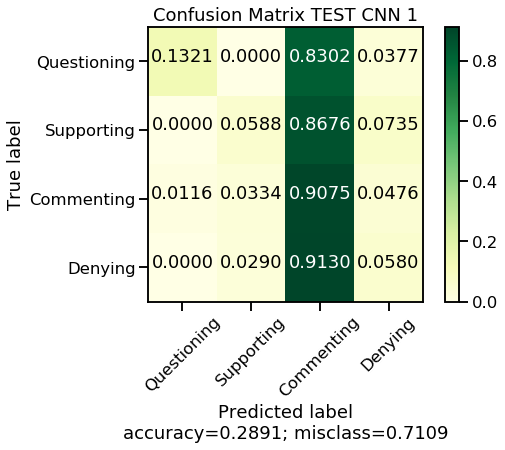

In [9]:
trainPredict = trained.predict(x_test, batch_size=32)
trainPredict=[np.argmax(pred) for pred in trainPredict]
acc_test= accuracy_score(etiq_t, trainPredict)  
f1_test=f1_score(etiq_t, trainPredict, average=None)  # labels=np.unique(trainPredict)
f1_test_ma=f1_score(etiq_t, trainPredict, average='macro')  # labels=np.unique(trainPredict)

matriz_test=confusion_matrix(etiq_t, trainPredict)
print ("Accuracy sobre validacion CNN FOCAL:",acc_test)  
print ("F1-score weighted sobre validación CNN FOCAL:",f1_test)
print ("F1-score macro sobre validación CNN FOCAL:",f1_test_ma)
plot_confusion_matrix(normalize(matriz_test,axis=1,norm='l1'),["Questioning","Supporting","Commenting","Denying"],"Confusion Matrix TEST CNN 1", cmap='YlGn')


### CNN1 AWE

In [78]:
x_new_train=np.zeros((x_train.shape[0],768))
i=0
for vector in x_train:
    n_vector=np.ones(768)
    for comp in vector:
        n_vector*=comp
    x_new_train[i]=n_vector
    i+=1
    
x_new_val=np.zeros((x_val.shape[0],768))
i=0
for vector in x_val:
    n_vector=np.ones(768)
    for comp in vector:
        n_vector*=comp
    x_new_val[i]=n_vector
    i+=1
    
x_new_test=np.zeros((x_test.shape[0],768))
i=0
for vector in x_test:
    n_vector=np.ones(768)
    for comp in vector:
        n_vector*=comp
    x_new_test[i]=n_vector
    i+=1

In [79]:
x_new_train.shape

(4238, 768)

In [81]:
x_new_train, y_new_train = sm.fit_sample(x_new_train, y_train)

In [82]:
x_new_train.shape

(10936, 768)

In [83]:
x_new_train=np.expand_dims(x_new_train, axis=-1)
x_new_val=np.expand_dims(x_new_val, axis=-1)
x_new_test=np.expand_dims(x_new_test, axis=-1)

In [84]:
x_new_train.shape

(10936, 768, 1)

 - val_f1: 0.000000 
 - val_f1: 0.000000 
 - val_f1: 0.000000 
 - val_f1: 0.000000 
 - val_f1: 0.000000 
 - val_f1: 0.000000 
 - val_f1: 0.000000 
 - val_f1: 0.000000 
 - val_f1: 0.000000 
 - val_f1: 0.000000 
 - val_f1: 0.000000 
 - val_f1: 0.000000 
 - val_f1: 0.000000 
 - val_f1: 0.000000 
 - val_f1: 0.000000 
 - val_f1: 0.000000 
 - val_f1: 0.000000 
 - val_f1: 0.000000 
 - val_f1: 0.000000 
 - val_f1: 0.000000 
 - val_f1: 0.000000 
 - val_f1: 0.000000 
 - val_f1: 0.000000 
 - val_f1: 0.000000 
 - val_f1: 0.000000 
 - val_f1: 0.000000 
 - val_f1: 0.000000 
 - val_f1: 0.000000 
 - val_f1: 0.000000 
 - val_f1: 0.000000 


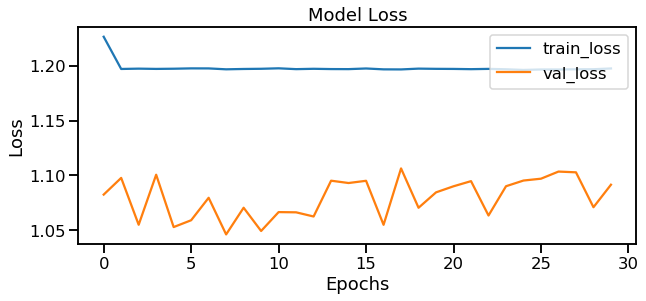

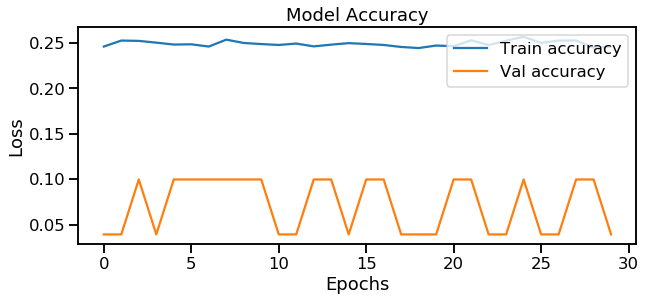

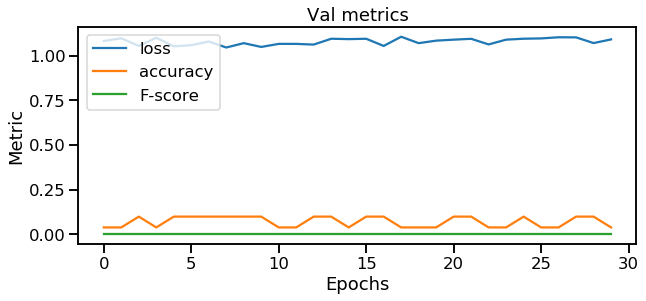

In [86]:
sequence_input = Input(shape=x_new_train.shape[1:])
batch = BatchNormalization()(sequence_input)
cov1= Conv1D(128, 5, activation='relu',padding='same')(batch)
pool = MaxPooling1D(pool_size=3)(cov1)    
batch = BatchNormalization()(pool)
drop = Dropout(0.65)(batch)
cov1= Conv1D(64, 5, activation='relu',padding='same')(drop)
pool = MaxPooling1D(pool_size=3)(cov1)
batch = BatchNormalization()(pool)
drop = Dropout(0.65)(batch)
flat = Flatten()(drop)
preds = Dense(100, activation='relu')(flat)
preds = BatchNormalization()(preds)
preds = Dense(4, activation='softmax')(preds)
cnn1 = Model(sequence_input, preds)

trained_awe =train_model(cnn1, x_new_train, y_new_train, x_new_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)

Accuracy sobre validacion CNN FOCAL: 0.06758080313418217
F1-score weighted sobre validación CNN FOCAL: [0.        0.        0.        0.1266055]
F1-score macro sobre validación CNN FOCAL: 0.031651376146788986


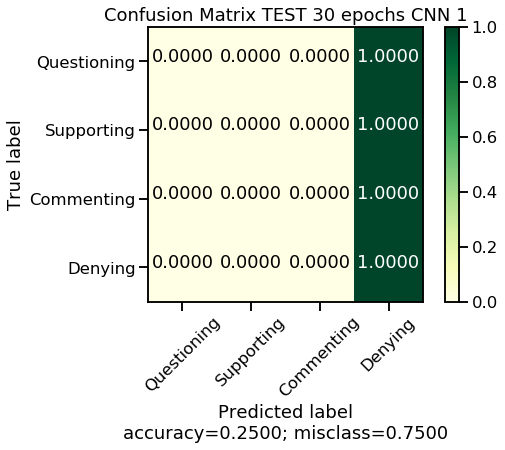

In [88]:
trainPredict = trained_awe.predict(x_new_test, batch_size=32)
trainPredict=[np.argmax(pred) for pred in trainPredict]
acc_test= accuracy_score(etiq_t, trainPredict)  
f1_test=f1_score(etiq_t, trainPredict, average=None)  # labels=np.unique(trainPredict)
f1_test_ma=f1_score(etiq_t, trainPredict, average='macro')  # labels=np.unique(trainPredict)

matriz_test=confusion_matrix(etiq_t, trainPredict)
print ("Accuracy sobre validacion CNN FOCAL:",acc_test)  
print ("F1-score weighted sobre validación CNN FOCAL:",f1_test)
print ("F1-score macro sobre validación CNN FOCAL:",f1_test_ma)
plot_confusion_matrix(normalize(matriz_test,axis=1,norm='l1'),["Questioning","Supporting","Commenting","Denying"],"Confusion Matrix TEST 30 epochs CNN 1", cmap='YlGn')


In [92]:
Counter([np.argmax(y) for y in y_new_train])

Counter({0: 2734, 2: 2734, 1: 2734, 3: 2734})

# Concatenate

### CNN2

In [10]:
del trained

 - val_f1: 0.098571 
 - val_f1: 0.281838 
 - val_f1: 0.294545 
 - val_f1: 0.345713 
 - val_f1: 0.420857 
 - val_f1: 0.302324 
 - val_f1: 0.389213 
 - val_f1: 0.338651 
 - val_f1: 0.390763 
 - val_f1: 0.433287 
 - val_f1: 0.386113 
 - val_f1: 0.395118 
 - val_f1: 0.369040 
 - val_f1: 0.419985 
 - val_f1: 0.391238 
 - val_f1: 0.382594 
 - val_f1: 0.372431 
 - val_f1: 0.399767 
 - val_f1: 0.339014 
 - val_f1: 0.376641 
 - val_f1: 0.412089 
 - val_f1: 0.351921 
 - val_f1: 0.406821 
 - val_f1: 0.389053 
 - val_f1: 0.397209 
 - val_f1: 0.420298 
 - val_f1: 0.443308 
 - val_f1: 0.363848 
 - val_f1: 0.380736 
 - val_f1: 0.362057 


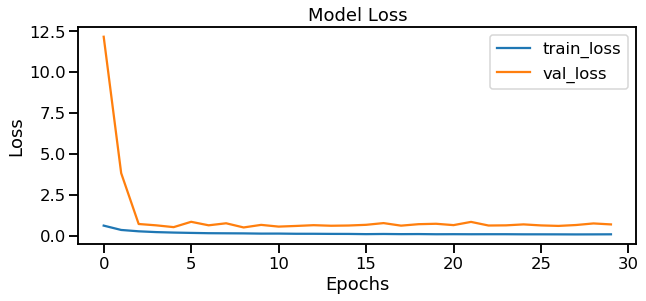

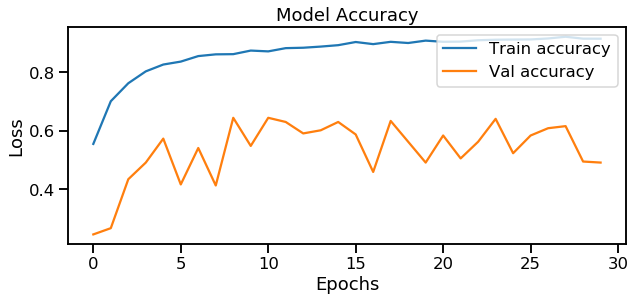

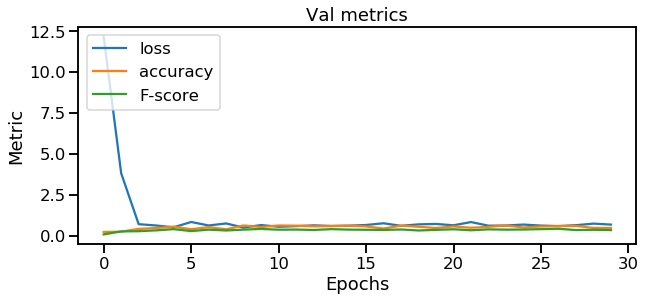

In [11]:
sequence_input = Input(shape=x_train.shape[1:])
batch = BatchNormalization()(sequence_input)
cov1= Conv1D(128, 5, activation='relu',padding='same')(batch)
pool = MaxPooling1D(pool_size=3)(cov1)    
batch = BatchNormalization()(pool)
drop = Dropout(0.65)(batch)
cov1= Conv1D(64, 5, activation='relu',padding='same')(drop)
pool = MaxPooling1D(pool_size=3)(cov1)
batch = BatchNormalization()(pool)
drop = Dropout(0.65)(batch)
flat = Flatten()(drop)
preds = Dense(128, activation='relu')(flat)
preds = BatchNormalization()(preds)
preds= Dropout(0.3)(preds)
preds = Dense(4, activation='softmax')(preds)
cnn2 = Model(sequence_input, preds)

trained =train_model(cnn2, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)

trained.save('baselines_fromCIARP_SMOTE/cnn2_30e_focal.h5') 

Accuracy sobre validacion CNN FOCAL: 0.40254652301665034
F1-score weighted sobre validación CNN FOCAL: [0.42156863 0.10989011 0.55298013 0.10285714]
F1-score macro sobre validación CNN FOCAL: 0.296824003162141


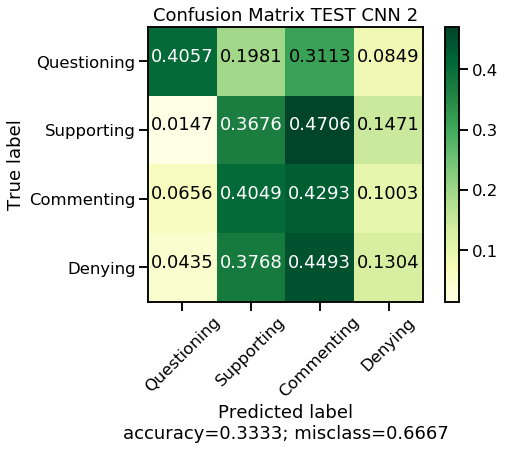

In [12]:
trainPredict = trained.predict(x_test, batch_size=32)
trainPredict=[np.argmax(pred) for pred in trainPredict]
acc_test= accuracy_score(etiq_t, trainPredict)  
f1_test=f1_score(etiq_t, trainPredict, average=None)  # labels=np.unique(trainPredict)
f1_test_ma=f1_score(etiq_t, trainPredict, average='macro')  # labels=np.unique(trainPredict)

matriz_test=confusion_matrix(etiq_t, trainPredict)
print ("Accuracy sobre validacion CNN FOCAL:",acc_test)  
print ("F1-score weighted sobre validación CNN FOCAL:",f1_test)
print ("F1-score macro sobre validación CNN FOCAL:",f1_test_ma)
plot_confusion_matrix(normalize(matriz_test,axis=1,norm='l1'),["Questioning","Supporting","Commenting","Denying"],"Confusion Matrix TEST CNN 2", cmap='YlGn')


### RNN1

In [7]:
from keras.layers import LSTM,GRU,Dense
from keras.utils import Sequence,to_categorical

def create_complex_GRU_2(unidades,unidades2,opt,input_s):
    model = Sequential()
    model.add(GRU(units=unidades,return_sequences=True,input_shape=input_s))
    model.add(Dropout(0.45))
    model.add(BatchNormalization())
    model.add(GRU(units=unidades2,return_sequences=False,input_shape=input_s ))#, recurrent_regularizer=regularizers.l1(0.01), kernel_regularizer=regularizers.l2(0.01) ))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Dense(4, activation='softmax')) # kernel_regularizer=regularizers.l2(0.01),activity_regularizer=regularizers.l1(0.01))
    #model.compile(loss=focal_loss(2,weights=class_weights), optimizer=opt, metrics=['acc'])
    return model

def create_complex_GRU_3(unidades,unidades2,unidades3,opt,input_s):
    model = Sequential()
    model.add(GRU(units=unidades,return_sequences=True,input_shape=input_s))
    model.add(Dropout(0.65))
    model.add(BatchNormalization())
    model.add(GRU(units=unidades2,return_sequences=True,input_shape=input_s ))#, recurrent_regularizer=regularizers.l1(0.01), kernel_regularizer=regularizers.l2(0.01) ))
    model.add(Dropout(0.45))
    model.add(BatchNormalization())
    model.add(GRU(units=unidades3,return_sequences=False,input_shape=input_s ))#,
    model.add(Dropout(0.35))
    model.add(BatchNormalization())
    model.add(Dense(4, activation='softmax')) # kernel_regularizer=regularizers.l2(0.01),activity_regularizer=regularizers.l1(0.01))
    #model.compile(loss=focal_loss(2,weights=class_weights), optimizer=opt, metrics=['acc'])
    return model

In [8]:
rnn1 = create_complex_GRU_2(128,64,"adam",x_train.shape[1:])
trained =train_model(rnn1, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)

trainPredict = trained.predict(x_test, batch_size=32)
trainPredict=[np.argmax(pred) for pred in trainPredict]
acc_test= accuracy_score(etiq_t, trainPredict)  
f1_test=f1_score(etiq_t, trainPredict, average=None)  # labels=np.unique(trainPredict)
f1_test_ma=f1_score(etiq_t, trainPredict, average='macro')  # labels=np.unique(trainPredict)

matriz_test=confusion_matrix(etiq_t, trainPredict)
print ("Accuracy sobre validacion RNN FOCAL:",acc_test)  
print ("F1-score weighted sobre validación RNN FOCAL:",f1_test)
print ("F1-score macro sobre validación RNN FOCAL:",f1_test_ma)
plot_confusion_matrix(normalize(matriz_test,axis=1,norm='l1'),["Questioning","Supporting","Commenting","Denying"],"Confusion Matrix TEST RNN 1", cmap='YlGn')

trained.save('baselines_fromCIARP_SMOTE/rnn1_30e_focal.h5') 

ResourceExhaustedError:  OOM when allocating tensor with shape[32,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gru_1/while/body/_1/MatMul_2}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_keras_scratch_graph_4345]

Function call stack:
keras_scratch_graph


### RNN2

In [ ]:
rnn2 = create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])

trained =train_model(rnn2, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)

trained.save('baselines_fromCIARP_SMOTE/rnn2_30e_focal.h5')  

In [ ]:
trainPredict = trained.predict(x_test, batch_size=32)
trainPredict=[np.argmax(pred) for pred in trainPredict]
acc_test= accuracy_score(etiq_t, trainPredict)  
f1_test=f1_score(etiq_t, trainPredict, average=None)  # labels=np.unique(trainPredict)
f1_test_ma=f1_score(etiq_t, trainPredict, average='macro')  # labels=np.unique(trainPredict)

matriz_test=confusion_matrix(etiq_t, trainPredict)
print ("Accuracy sobre validacion RNN 2 FOCAL:",acc_test)  
print ("F1-score weighted sobre validación RNN 2 FOCAL:",f1_test)
print ("F1-score macro sobre validación RNN 2 FOCAL:",f1_test_ma)
plot_confusion_matrix(normalize(matriz_test,axis=1,norm='l1'),["Questioning","Supporting","Commenting","Denying"],"Confusion Matrix TEST RNN 2", cmap='YlGn')


### RNN3

In [ ]:
rnn3 = create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])

trained =train_model(rnn3, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=False)

trained.save('baselines_fromCIARP_SMOTE/rnn3_30e_cce.h5')  #CCE

In [ ]:
trainPredict = trained.predict(x_test, batch_size=32)
trainPredict=[np.argmax(pred) for pred in trainPredict]
acc_test= accuracy_score(etiq_t, trainPredict)  
f1_test=f1_score(etiq_t, trainPredict, average=None)  
f1_test_ma=f1_score(etiq_t, trainPredict, average='macro') 

matriz_test=confusion_matrix(etiq_t, trainPredict)
print ("Accuracy sobre validacion RNN CCe:",acc_test)  
print ("F1-score weighted sobre validación RNN CCE:",f1_test)
print ("F1-score macro sobre validación RNN CCE:",f1_test_ma)
plot_confusion_matrix(normalize(matriz_test,axis=1,norm='l1'),["Questioning","Supporting","Commenting","Denying"],"Confusion Matrix TEST RNN 3", cmap='YlGn')
